In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### EDA

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.shape, test.shape

((159571, 8), (153164, 2))

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['non-toxic'] = 1-train[label_cols].max(axis=1)
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,non-toxic
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
def get_top_ngrams(corpus, ngram = 2, n=None):
    vec = CountVectorizer(ngram_range=(ngram, ngram)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<AxesSubplot:>

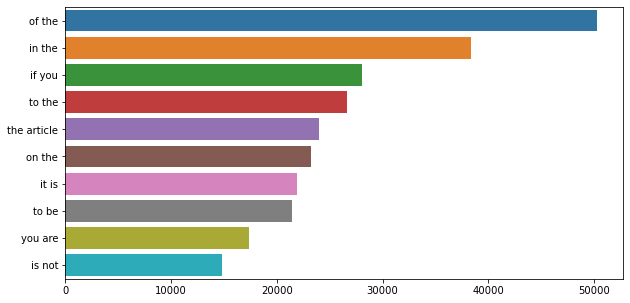

In [11]:
plt.figure(figsize=(10,5))
top_bigrams=get_top_ngrams(train['comment_text'])[:10]
x,y=map(list,zip(*top_bigrams))
sns.barplot(x=y,y=x)

### Preprocessing

In [5]:
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from spellchecker import SpellChecker
import textblob
import os
import tensorflow as tf

/Users/jixidai/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [6]:
def remove_URL(comment_text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',comment_text)

def remove_html(comment_text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',comment_text)

def remove_emoji(comment_text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', comment_text)

def remove_punct(comment_text):
    table=str.maketrans('','',string.punctuation)
    return comment_text.translate(table)

def correct_spellings(comment_text):
    spell = SpellChecker()
    corrected_comment_text = []
    misspelled_words = spell.unknown(comment_text.split())
    for word in comment_text.split():
        if word in misspelled_words:
            corrected_comment_text.append(spell.correction(word))
        else:
            corrected_comment_text.append(word)
    return " ".join(corrected_comment_text)

def check_pos_tag(x, flag):
    pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' : ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
    }
    cnt = 0
    wiki = textblob.TextBlob(x)
    for tup in wiki.tags:
        ppo = list(tup)[1]
        if ppo in pos_family[flag]:
            cnt += 1
    return cnt

def preprocess(df):
    
    df['comment_text']=df['comment_text'].apply(lambda x : remove_URL(x))
    df['comment_text']=df['comment_text'].apply(lambda x : remove_html(x))
    df['comment_text']=df['comment_text'].apply(lambda x: remove_emoji(x))
    df['comment_text'] = df['comment_text'].str.lower()
    #df['comment_text']=df['comment_text'].apply(lambda x : correct_spellings(x))
    df['upper_case_word_count'] = df['comment_text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
    df['word_count'] = df['comment_text'].apply(lambda x: len(x.split()))
    df['punctuation_count'] = df['comment_text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation)))
    df['comment_text']=df['comment_text'].apply(lambda x : remove_punct(x))
    df['noun_count'] = df['comment_text'].apply(lambda x: check_pos_tag(x, 'noun'))
    df['verb_count'] = df['comment_text'].apply(lambda x: check_pos_tag(x, 'verb'))
    df['adj_count'] = df['comment_text'].apply(lambda x: check_pos_tag(x, 'adj'))
    df['adv_count'] = df['comment_text'].apply(lambda x: check_pos_tag(x, 'adv'))
    df['pron_count'] = df['comment_text'].apply(lambda x: check_pos_tag(x, 'pron'))
    df['comment_text'].fillna("unknown", inplace=True)
    return df
    


In [ ]:
train_df = preprocess(train)
test_df = preprocess(test)
train_df.to_csv('train_temp.csv', index = False)
test_df.to_csv('test_temp.csv', index = False)

In [7]:
train_df = pd.read_csv('train_temp.csv')
test_df = pd.read_csv('test_temp.csv')

train_df['comment_text'].fillna("unknown", inplace=True)
test_df['comment_text'].fillna("unknown", inplace=True)

<AxesSubplot:>

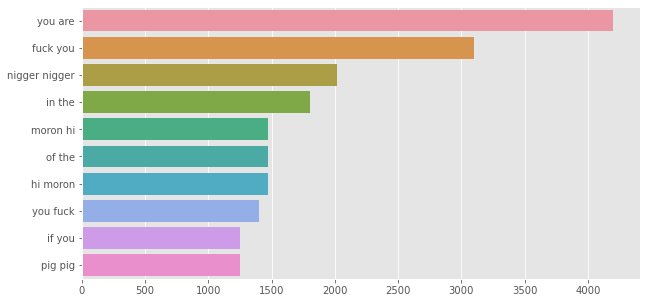

In [12]:
### Most frequent words in toxic comment
plt.figure(figsize=(10,5))
top_bigrams=get_top_ngrams(train_df[train_df['toxic'] == 1]['comment_text'])[:10]
x,y=map(list,zip(*top_bigrams))
sns.barplot(x=y,y=x)

<AxesSubplot:>

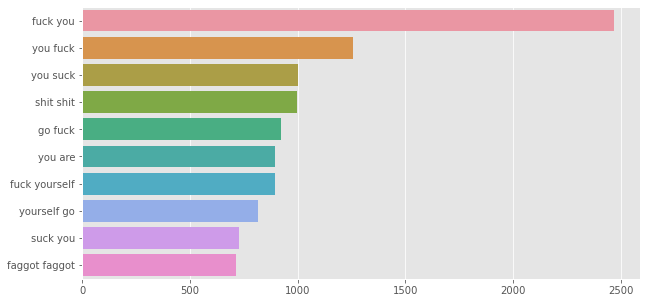

In [13]:
### Most frequent words in severe toxic comment
plt.figure(figsize=(10,5))
top_bigrams=get_top_ngrams(train_df[train_df['severe_toxic'] == 1]['comment_text'])[:10]
x,y=map(list,zip(*top_bigrams))
sns.barplot(x=y,y=x)

### Model

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import imblearn
import gensim.downloader
from gensim.models import Word2Vec
#import lightgbm as lgb

In [9]:
class NLTKPreprocessor(BaseEstimator, TransformerMixin):

    def __init__(self, stopwords=None, punct=None,
                 lower=True, strip=True):
        self.lower      = lower
        self.strip      = strip
        self.stopwords  = stopwords or set(sw.words('english'))
        self.punct      = punct or set(string.punctuation)
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def inverse_transform(self, X):
        return [" ".join(doc) for doc in X]

    def transform(self, X):
        return [' '.join(self.tokenize(doc)) for doc in X]

    def tokenize(self, sentence):
        for token, tag in pos_tag(wordpunct_tokenize(sentence)):
            # Apply preprocessing to the token
            token = token.lower() if self.lower else token
            token = token.strip() if self.strip else token
            token = token.strip('_') if self.strip else token
            token = token.strip('*') if self.strip else token

            # If stopword, ignore token and continue
            if token in self.stopwords:
                continue

            # If punctuation, ignore token and continue
            if all(char in self.punct for char in token):
                continue

            # Lemmatize the token and yield
            lemma = self.lemmatize(token, tag)
            yield lemma

    def lemmatize(self, token, tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

#### Machine Learning Models

In [10]:
def build_vectorizer(vectorizer, corpus, stop_words = None, preprocessor = None):
        if stop_words:    
            vectorizer.set_params(stop_words = stop_words)

        if preprocessor:
            corpus = preprocessor.fit(corpus)
            corpus = preprocessor.transform(corpus)
            vectorizer.set_params(tokenizer = None, preprocessor=None, lowercase=False)

        vectorizer.fit(corpus)
    
        return vectorizer

def build(X, y, vectorizer, classifier, stop_words = None, preprocessor = None):
    """
    Use imblearn pipelien to build model
    """
    
    if isinstance(classifier, type):
        classifier = classifier()

    vectorizer = build_vectorizer(vectorizer, X, stop_words = stop_words, preprocessor = preprocessor)
    over = imblearn.over_sampling.SMOTE(sampling_strategy=0.2)
    under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5)
    steps = [('vectorizer', vectorizer), ('o', over), ('u', under), ('classifier', classifier)]
    model = imblearn.pipeline.Pipeline(steps=steps)
    model.fit(X, y)
    return model

def build_and_evaluate(X, y, vectorizer, stop_words = None, 
                       preprocessor = None, classifier = MultinomialNB()):
    
    accuracys = []
    recalls = []
    precisions = []
    roc_aucs = []
    for i, label in enumerate(label_cols):
        X_train, X_valid, y_train, y_valid = train_test_split(X, y[label], test_size=0.2, random_state = 0)
        model = build(X_train, y_train, vectorizer, classifier)
        y_pred = model.predict(X_valid)
        accuracys.append(accuracy_score(y_valid, y_pred))
        recalls.append(recall_score(y_valid, y_pred))
        precisions.append(precision_score(y_valid, y_pred))
        roc_aucs.append(roc_auc_score(y_valid, y_pred))

    classifier_name = type(classifier).__name__
    print("Classification Report for {} + {}:\n".format(classifier_name, type(vectorizer).__name__))
    print("Average accuracy across all labels is {}".format(np.mean(accuracys)))
    print("Average recall across all labels is {}".format(np.mean(recalls)))
    print("Average precision across all labels is {}".format(np.mean(precisions)))
    print("Average auc score across all labels is {}".format(np.mean(roc_aucs)))

def build_and_predict(X_train, y_train, X_test, vectorizer, stop_words = None, 
                       preprocessor = None, classifier = MultinomialNB()):
    preds = np.zeros((len(X_test), len(label_cols)))
    for i, label in enumerate(label_cols):
        model = build(X_train, y_train[label], vectorizer, classifier)
        preds[:,i] = model.predict(X_test)
    return preds

    

In [38]:
#NB-TFIDF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1, smooth_idf=1, sublinear_tf=1 )
build_and_evaluate(train_df['comment_text'], train_df[label_cols], tfidf_vectorizer, stop_words = stop, 
                       preprocessor = None, classifier = MultinomialNB())
nb_tfidf_prediction = build_and_predict(train_df['comment_text'], train_df[label_cols], test_df['comment_text'], tfidf_vectorizer, stop_words = None, 
                       preprocessor = None, classifier = MultinomialNB())

Classification Report for MultinomialNB + TfidfVectorizer:

Average accuracy across all labels is 0.9671732205337092
Average recall across all labels is 0.6432932204150239
Average precision across all labels is 0.4673019017439939
Average auc score across all labels is 0.8129398889167899


In [39]:
#NB-COUNT
count_vectorizer = CountVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9, strip_accents='unicode')
build_and_evaluate(train_df['comment_text'], train_df[label_cols], count_vectorizer, stop_words = stop, 
                       preprocessor = None, classifier = MultinomialNB())
nb_count_prediction = build_and_predict(train_df['comment_text'], train_df[label_cols], test_df['comment_text'], count_vectorizer, stop_words = None, 
                       preprocessor = None, classifier = MultinomialNB())

Classification Report for MultinomialNB + CountVectorizer:

Average accuracy across all labels is 0.9613191289362368
Average recall across all labels is 0.6392057318809118
Average precision across all labels is 0.36712336615347546
Average auc score across all labels is 0.8045366058477353


In [14]:
#LR-TFIDF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1, smooth_idf=1, sublinear_tf=1 )
build_and_evaluate(train_df['comment_text'], train_df[label_cols], tfidf_vectorizer, stop_words = stop, 
                       preprocessor = None, classifier = LogisticRegression())
lr_tfidf_prediction = build_and_predict(train_df['comment_text'], train_df[label_cols], test_df['comment_text'], tfidf_vectorizer, stop_words = None, 
                       preprocessor = None, classifier = LogisticRegression())

/Users/jixidai/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jixidai/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Classification Report for LogisticRegression + TfidfVectorizer:

Average accuracy across all labels is 0.9666457778474072
Average recall across all labels is 0.7405630175796806
Average precision across all labels is 0.44368636740009854
Average auc score across all labels is 0.857318908373903


/Users/jixidai/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jixidai/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

In [35]:
#TFIDF-RF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1, smooth_idf=1, sublinear_tf=1 )
build_and_evaluate(train_df['comment_text'], train_df[label_cols], tfidf_vectorizer, stop_words = stop, 
                       preprocessor = None, classifier = RandomForestClassifier())
rf_tfidf_prediction = build_and_predict(train_df['comment_text'], train_df[label_cols], test_df['comment_text'], count_vectorizer, stop_words = None, 
                       preprocessor = None, classifier = RandomForestClassifier())

Classification Report for RandomForestClassifier + TfidfVectorizer:

Average accuracy across all labels is 0.9767402997545563
Average recall across all labels is 0.7528162178456047
Average precision across all labels is 0.2562449838934063


In [15]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = self.word2vec.vector_size

    def fit(self, X, y = None):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [19]:
#Pretrained Word2Vec - NB
glove_vectors = gensim.downloader.load('glove-twitter-200')
tweet2vec = MeanEmbeddingVectorizer(glove_vectors)

build_and_evaluate(train_df['comment_text'], train_df[label_cols], tweet2vec, stop_words = stop, 
                       preprocessor = None, classifier = GaussianNB())


Classification Report for GaussianNB + MeanEmbeddingVectorizer:

Average accuracy across all labels is 0.8198913781398507
Average recall across all labels is 0.5867393215556616
Average precision across all labels is 0.09830615600713659
Average auc score across all labels is 0.7088134622343905


In [ ]:
#word2vec trained on current dataset

word2vec = Word2Vec(vector_size = 300, min_count=1)
train_text = [[word for word in tweet.lower().split()] for tweet in train_df.text]
word2vec.build_vocab(train_text)
word2vec.train(train_text, total_examples = len(train_df), epochs = word2vec.epochs)

tweet2vec = MeanEmbeddingVectorizer(word2vec.wv)
train_word2vec = tweet2vec.transform(train_x.text)
valid_word2vec = tweet2vec.transform(valid_x.text)

#### NB-SVM

In [29]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from scipy import sparse

def pr(x, y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))
    
    def cross_validation(self, x, y):
        kf = KFold(n_split = 5, random_state = 0, shuffle = True)
        return np.mean(cross_val_score(self, x, y, cv = kf))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)
        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self

In [31]:
preds = np.zeros((len(test_df), len(label_cols)))
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1, smooth_idf=1, sublinear_tf=1 )
train_tfidf = tfidf_vectorizer.fit_transform(train_df['comment_text'])
test_tfidf = tfidf_vectorizer.transform(test_df['comment_text'])

for i, label in enumerate(label_cols):
    model = NbSvmClassifier(C=4, dual=False, n_jobs=-1).fit(train_tfidf, train_df[label])
    preds[:,i] = model.predict(test_tfidf)


#### Deep Learning Models

### Submission

In [42]:
#NB-COUNT public: 0.7336
sample_sub = pd.read_csv('sample_submission.csv')
submid = pd.DataFrame({'id': sample_sub["id"]})
submission = pd.concat([submid, pd.DataFrame(nb_count_prediction, columns = label_cols)], axis=1)
submission.to_csv('submission.csv', index=False)

In [33]:
#NB-LR public: 0.745
sample_sub = pd.read_csv('sample_submission.csv')
submid = pd.DataFrame({'id': sample_sub["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = label_cols)], axis=1)
submission.to_csv('submission.csv', index=False)

In [ ]:
#NB-TFIDF public: 0.81
sample_sub = pd.read_csv('sample_submission.csv')
submid = pd.DataFrame({'id': sample_sub["id"]})
submission = pd.concat([submid, pd.DataFrame(nb_tfidf_prediction, columns = label_cols)], axis=1)
submission.to_csv('submission.csv', index=False)

In [17]:
#LR-TFIDF public: 0.86
sample_sub = pd.read_csv('sample_submission.csv')
submid = pd.DataFrame({'id': sample_sub["id"]})
submission = pd.concat([submid, pd.DataFrame(lr_tfidf_prediction, columns = label_cols)], axis=1)
submission.to_csv('submission.csv', index=False)